# Withdrawal prediction on behavioral indicators

In this section, we try to reproduce the withdrawal prediction approach based on
behavioral indicators and Synthetic Minority Over-sampling (SMOTE) as presented in
the work of Hlioui et al. {cite}`hlioui_2021`.

Given the recurring occurrence of elevated learner withdrawal rates in Massive Open
Online Courses (MOOCs), the implementation of early withdrawal prediction models
could facilitate pedagogical enhancements, enable tailored intervention strategies
and empower learners to monitor and enhance their academic performance.

The approach of Hlioui et al. encloses four main phases:
1. Data preprocessing
2. Behavioral indicators extraction (feature engineering)
3. K-means-based Data Discretizing
4. Withdrawal prediction

```{bibliography}
:filter: docname in docnames
```

In [1]:
from itertools import chain

import pandas as pd
from imblearn.over_sampling import SMOTE
from IPython.display import display
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from oulad import filter_by_module_presentation, get_oulad

%load_ext oulad.capture

In [2]:
%%capture oulad
oulad = get_oulad()

## Data preprocessing

As in the work of Hlioui et al., we use the data from the `DDD` course `2013B`
presentation.
We start by extracting three tables containing data related to student demographics,
student assessments and student course interactions.

In [3]:
MODULE = "DDD"
PRESENTATION = "2013B"

### Student demographics table

In [4]:
student_info = filter_by_module_presentation(
    oulad.student_info, MODULE, PRESENTATION
).drop(columns=["studied_credits", "imd_band"])
display(student_info)

,id_student,gender,region,highest_education,age_band,num_of_prev_attempts,disability,final_result
13091,24213,F,East Anglian Region,A Level or Equivalent,0-35,0,N,Withdrawn
13092,40419,M,East Midlands Region,Lower Than A Level,35-55,0,N,Withdrawn
13093,41060,M,Ireland,HE Qualification,0-35,0,N,Fail
13094,43284,M,East Midlands Region,Lower Than A Level,0-35,2,N,Withdrawn
13095,45664,M,Yorkshire Region,HE Qualification,0-35,1,N,Pass
...,...,...,...,...,...,...,...,...
14389,2693243,F,Yorkshire Region,Lower Than A Level,35-55,0,N,Distinction
14390,2694933,F,East Midlands Region,A Level or Equivalent,0-35,0,Y,Pass
14391,2697773,F,East Anglian Region,A Level or Equivalent,0-35,0,N,Fail
14392,2707979,F,East Midlands Region,Lower Than A Level,0-35,0,N,Fail


### Student assessments table

In [5]:
assessments = filter_by_module_presentation(oulad.assessments, MODULE, PRESENTATION)
student_assessments = assessments.merge(
    oulad.student_assessment, on="id_assessment"
).drop(columns=["is_banked", "assessment_type", "id_assessment"])
display(student_assessments)

,date,weight,id_student,date_submitted,score
0,23.0,2.0,907261,25,80.0
1,23.0,2.0,957467,25,77.0
2,23.0,2.0,1018685,25,40.0
3,23.0,2.0,1044992,25,73.0
4,23.0,2.0,1068316,25,67.0
...,...,...,...,...,...
10368,240.0,100.0,2677955,230,69.0
10369,240.0,100.0,2683836,230,71.0
10370,240.0,100.0,2689536,229,58.0
10371,240.0,100.0,2693243,230,82.0


### Student course interactions table

In [6]:
%%capture -ns withdrawal_prediction_on_behavioral_indicators student_vle
student_vle = (
    filter_by_module_presentation(oulad.student_vle, MODULE, PRESENTATION)
    .merge(filter_by_module_presentation(oulad.vle, MODULE, PRESENTATION), on="id_site")
    .drop(columns=["id_site", "date", "week_from", "week_to"])
)
display(student_vle)

,id_student,sum_click,activity_type
0,430516,3,page
1,430516,6,homepage
2,430516,2,url
3,420388,1,url
4,420388,3,homepage
...,...,...,...
536832,536170,2,resource
536833,536926,1,homepage
536834,556295,3,homepage
536835,556780,1,homepage


### Distribution of learners' results in the course DDD2013B

Next, we reproduce the pie chart from the paper of Hlioui et al. (Figure 3)
which reveals class imbalance of student final outcome in the `DDD2013B` course
presentation.

The class imbalance problem is a commonly recognized challenge in Machine Learning,
known to hinder the development of effective classifiers. (Batista, et al., 2004)

When trained on imbalanced datasets, models often exhibit a significant bias toward
the majority class.
This bias occurs because traditional Machine Learning algorithms are primarily
focused on maximizing overall prediction accuracy, which can lead them to overlook or
neglect classes with fewer instances, typically referred to as the minority class.
(Bekkar & Alitouche, 2013)

To deal with the class imbalance problem, the approach of Hlioui et al. applies the
Synthetic Minority Over-sampling method (SMOTE) on the dataset, which generates new
observations in the minority class by interpolating the existing ones.

```{note}
At this juncture, we deviate marginally from the initial approach as we apply the
SMOTE method subsequent to the extraction of behavioral indicators.
```

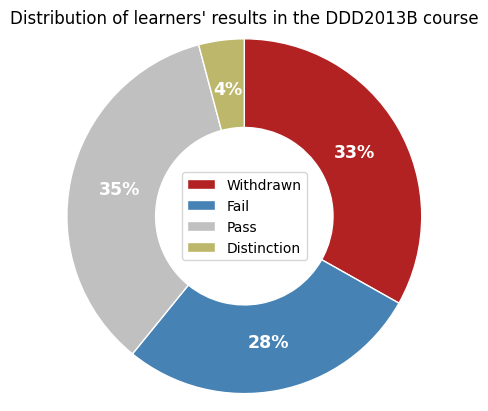

In [7]:
(
    student_info.final_result.value_counts()
    .loc[["Withdrawn", "Fail", "Pass", "Distinction"]]
    .plot.pie(
        title="Distribution of learners' results in the DDD2013B course",
        ylabel="",
        wedgeprops={"width": 0.6, "edgecolor": "w"},
        autopct="%1.0f%%",
        pctdistance=0.72,
        colors=["firebrick", "steelblue", "silver", "darkkhaki"],
        startangle=-270,
        counterclock=False,
        labeldistance=None,
        radius=1.2,
        textprops={"color": "white", "weight": "bold", "fontsize": 12.5},
    )
)
plt.legend(loc="center")
plt.show()

## Behavioral indicators extraction

At this stage we extract behavioral indicators as described in the work of Hlioui et
al.

### Autonomy

The autonomy indicator refers to the navigation frequency of learners within the
virtual learning environment (VLE).

In [8]:
autonomy = (
    student_vle.drop(columns="activity_type")
    .groupby(["id_student"])
    .count()
    .rename(columns={"sum_click": "autonomy"})
)
display(autonomy)

,autonomy
id_student,
40419,60
41060,214
43284,422
45664,405
52014,116
...,...
2691780,156
2692101,151
2693243,1249


### Perseverance

The perseverance indicator refers to the ratio of evaluations submitted on time by
the learners.

In [9]:
perseverance = (
    student_assessments.query("date_submitted <= date")[["id_student", "score"]]
    .groupby("id_student")
    .count()
    .div(assessments.shape[0])
    .rename(columns={"score": "perseverance"})
)
display(perseverance)

,perseverance
id_student,
40419,0.071429
41060,0.357143
43284,0.214286
45664,0.500000
52014,0.357143
...,...
2689536,0.285714
2691780,0.214286
2692101,0.071429


### Commitment indicators

Commitment indicators aim to measure the level and type of involvement of learners.
In the work of Hlioui et al. they refer to the total sum of clicks (interactions)
made by learners on several related activity types (activity categories).

Below, a barplot is presented, illustrating the frequency distribution of
interactions by activity type within the DDD2013B course.

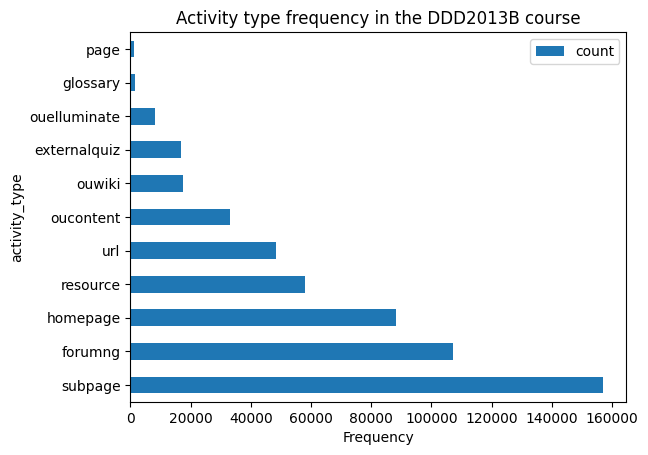

In [10]:
student_vle.activity_type.value_counts().to_frame().plot.barh(
    title="Activity type frequency in the DDD2013B course", xlabel="Frequency"
)
plt.show()

### Collaborative commitment

The collaborative commitment indicator refers to the sum of clicks learners made on
activities of type `forumng`, `ouwiki`, and `ouelluminate`.

In [11]:
collaborative_commitment = (
    student_vle.query("activity_type in ['forumng', 'ouwiki', 'ouelluminate']")
    .drop(columns="activity_type")
    .groupby("id_student")
    .sum()
    .rename(columns={"sum_click": "collaborative_commitment"})
)
display(collaborative_commitment)

,collaborative_commitment
id_student,
40419,69
41060,46
43284,176
45664,181
52014,110
...,...
2691780,43
2692101,32
2693243,941


### Course structure commitment

The course structure commitment indicator refers to the sum of clicks learners made on
activities of type `homepage` and `glossary`.

In [12]:
course_structure_commitment = (
    student_vle.query("activity_type in ['homepage', 'glossary']")
    .drop(columns="activity_type")
    .groupby("id_student")
    .sum()
    .rename(columns={"sum_click": "course_structure_commitment"})
)
display(course_structure_commitment)

,course_structure_commitment
id_student,
40419,29
41060,80
43284,293
45664,287
52014,98
...,...
2691780,87
2692101,69
2693243,591


### Course content commitment

The course content commitment indicator refers to the sum of clicks learners made on
activities of type `resource`, `url`, `oucontent`, `page`, and `subpage`.

In [13]:
course_content_commitment = (
    student_vle.query(
        "activity_type in ['resource', 'url', 'oucontent', 'page', 'subpage']"
    )
    .drop(columns="activity_type")
    .groupby("id_student")
    .sum()
    .rename(columns={"sum_click": "course_content_commitment"})
)
display(course_content_commitment)

,course_content_commitment
id_student,
40419,45
41060,270
43284,348
45664,558
52014,132
...,...
2691780,154
2692101,215
2693243,1050


### Evaluation activities commitment

The evaluation activities commitment indicator refers to the sum of clicks learners
made on activities of type `extenalquiz`.

In [14]:
evalutation_activities_commitment = (
    student_vle.query("activity_type == 'externalquiz'")
    .drop(columns="activity_type")
    .groupby("id_student")
    .sum()
    .rename(columns={"sum_click": "evalutation_activities_commitment"})
)
display(evalutation_activities_commitment)

,evalutation_activities_commitment
id_student,
40419,1
41060,15
43284,30
45664,22
52014,9
...,...
2689536,8
2691780,24
2692101,2


### Motivation

The motivation indicator measures whether a learners' sum of clicks on all activities
is above average (motivated) or below (unmotivated).

In [15]:
motivation = (
    student_vle.drop(columns="activity_type")
    .groupby("id_student")
    .sum()
    .assign(motivation=lambda df: df.sum_click >= df.sum_click.mean())
    .drop(columns="sum_click")
    .astype(float)
)
display(motivation)

,motivation
id_student,
40419,0.0
41060,0.0
43284,0.0
45664,0.0
52014,0.0
...,...
2691780,0.0
2692101,0.0
2693243,1.0


## Performance

The performance indicator refers to the sum of weighted assessment scores by learner.

In [16]:
performance = (
    student_assessments.assign(performance=lambda df: df.weight * df.score)
    .drop(columns=["date", "date_submitted", "weight", "score"])
    .groupby("id_student")
    .sum()
)
display(performance)

,performance
id_student,
40419,704.0
41060,6359.5
43284,4020.0
45664,9528.0
52014,4424.0
...,...
2689536,10621.0
2691780,2703.0
2692101,1819.0


## K-Means-based data discretizing

At this stage, we discretize the generated indicators using the K-Means clustering
method.
We begin by estimating the 'k' parameter through the elbow method and then replace
the indicators' values with their corresponding clustering labels.

### Elbow method

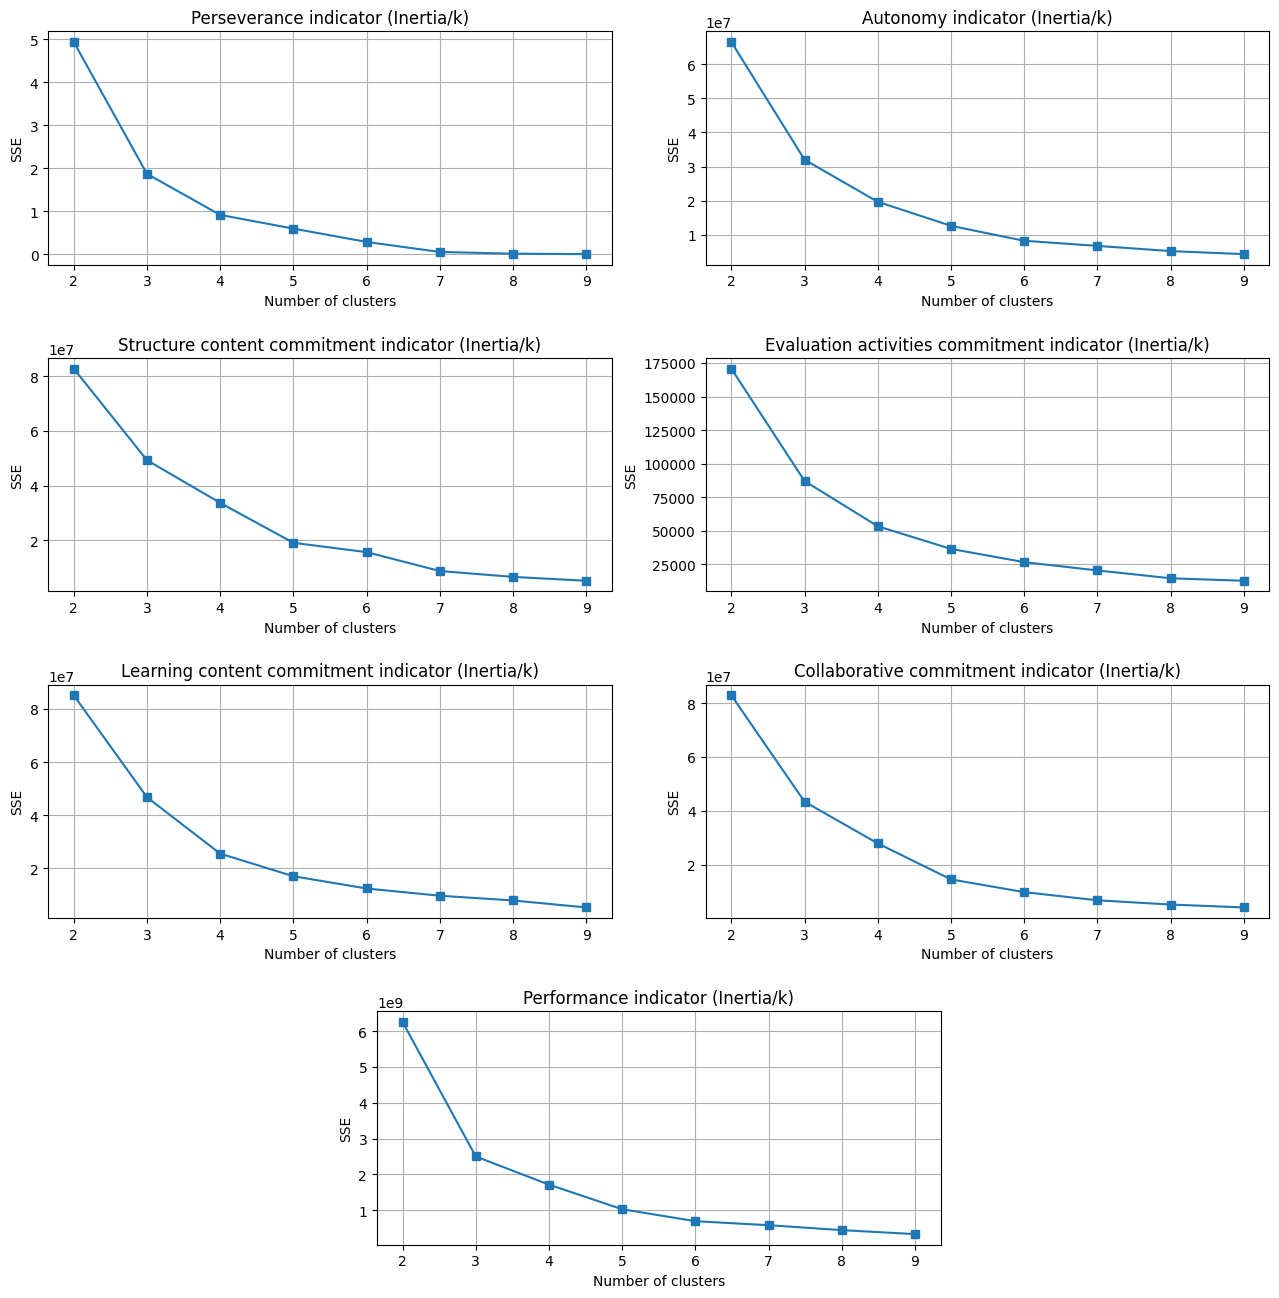

In [17]:
%%capture -ns withdrawal_prediction_on_behavioral_indicators inertia
indicators = {
    "Perseverance indicator": perseverance,
    "Autonomy indicator": autonomy,
    "Structure content commitment indicator": course_structure_commitment,
    "Evaluation activities commitment indicator": evalutation_activities_commitment,
    "Learning content commitment indicator": course_content_commitment,
    "Collaborative commitment indicator": collaborative_commitment,
    "Performance indicator": performance,
}
k_range = list(range(2, 10))
fig = plt.figure(figsize=(20, 20))
# Inertia: Sum of squared distances of samples to their closest cluster center,
# weighted by the sample weights if provided.
inertia = [
    KMeans(n_clusters=k, n_init="auto").fit(indicator.values).inertia_
    for indicator in indicators.values()
    for k in k_range
]
for i, name in enumerate(indicators):
    index = i * len(k_range)
    pd.Series(inertia[index : index + len(k_range)], index=k_range, name="k").plot(
        title=f"{name} (Inertia/k)",
        xlabel="Number of clusters",
        ylabel="SSE",
        grid=True,
        marker="s",
        ax=plt.subplot2grid((5, 5), (int(i / 2), 2 * (i % 2) + int(i / 6)), colspan=2),
    )

plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

### Discretization

We obtain similar graphs as in the work of Hlioui et al.
Thus, we proceed by setting the same `k` values.

In [18]:
selected_k = {
    "Perseverance indicator": 3,
    "Autonomy indicator": 3,
    "Structure content commitment indicator": 2,
    "Evaluation activities commitment indicator": 3,
    "Learning content commitment indicator": 2,
    "Collaborative commitment indicator": 3,
    "Performance indicator": 3,
}
for name, k in selected_k.items():
    kmeans = KMeans(n_clusters=k, n_init="auto")
    indicator = indicators[name]
    indicator[indicator.columns[0]] = kmeans.fit_predict(indicator)

### Feature table

We join the student demographics table with the discretized behavioral
indicators into a single `feature_table`.

We also encode categorical columns (`age_band`, `disability`, `gender`,
`highest_education`, `region`, and `final_result`) to numerical values and fill
missing values with zeros.

In [19]:
region_encoder = OrdinalEncoder()
feature_table = (
    student_info.set_index("id_student")
    .join(chain([motivation], indicators.values()), how="outer")
    .fillna(0.0)
    .replace(
        {
            "age_band": {"0-35": "0.0", "35-55": "0.5", "55<=": "1.0"},
            "disability": {"N": "0.0", "Y": "1.0"},
            "gender": {"M": "0.0", "F": "1.0"},
            "highest_education": {
                "No Formal quals": "0.0",
                "Lower Than A Level": "0.25",
                "A Level or Equivalent": "0.5",
                "HE Qualification": "0.75",
                "Post Graduate Qualification": "1.0",
            },
            "final_result": {
                "Withdrawn": "1.0",
                "Fail": "0.0",
                "Pass": "0.0",
                "Distinction": "0.0",
            },
        }
    )
    .assign(region=lambda df: region_encoder.fit_transform(df[["region"]]))
    .astype(float)
)
display(feature_table)

,gender,region,highest_education,age_band,num_of_prev_attempts,disability,final_result,motivation,perseverance,autonomy,course_structure_commitment,evalutation_activities_commitment,course_content_commitment,collaborative_commitment,performance
id_student,,,,,,,,,,,,,,,
24213,1.0,0.0,0.50,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40419,0.0,1.0,0.25,0.5,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0
41060,0.0,2.0,0.75,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,2.0,0.0,1.0,2.0
43284,0.0,1.0,0.25,0.0,2.0,0.0,1.0,0.0,2.0,1.0,1.0,0.0,0.0,1.0,1.0
45664,0.0,12.0,0.75,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2693243,1.0,12.0,0.25,0.5,0.0,0.0,0.0,1.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0
2694933,1.0,1.0,0.50,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
2697773,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## Withdrawal prediction

Prior to training the classification models, we split the `feature_table` into a
train (75%) and test (25%) set.
Then we scale features to values between 0 and 1 and apply the SMOTE method to
balance the occurences of the target class (Withdrawn/Not Withdrawn).


In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    feature_table.drop(columns="final_result").values, feature_table.final_result.values
)
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
smote = SMOTE()
x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

Subsequently, we undertake a grid search across classification parameters for five
classifiers, which have been chosen to align closely with those
utilized in the work of Hlioui et al.
These classifiers encompass Decision Trees, Random Forest, Support Vector Machines,
Gaussian Naive Bayes (as a substitute for Tree Augmented Naive Bayes), and
Multilayer Perceptron.

In line with the work of Hlioui et al., we adopt a 5-fold cross-validation approach
with stratification.
Evaluation of classifier performance is conducted utilizing the F-measure as the
primary metric.

```{note}
We replaced the initial parameter ranges with the selected values after the first
grid search run to speed up the process.
```

In [21]:
%%capture -ns withdrawal_prediction_on_behavioral_indicators scores
grid = {
    DecisionTreeClassifier: {
        "unbalanced": {
            "criterion": ["log_loss"],  # ["gini", "entropy", "log_loss"],
            "max_depth": [3],  # [None, *list(range(1, 20))],
            "min_samples_leaf": [13],  # range(1, 20),
            "min_samples_split": [9],  # range(2, 20),
            "splitter": ["random"],  # ["random", "best"],
        },
        "balanced": {
            "criterion": ["entropy"],  # ["gini", "entropy", "log_loss"],
            "max_depth": [8],  # [None, *list(range(1, 20))],
            "min_samples_leaf": [1],  # range(1, 20),
            "min_samples_split": [12],  # range(2, 20),
            "splitter": ["random"],  # ["random", "best"],
        },
    },
    RandomForestClassifier: {
        "unbalanced": {
            "criterion": ["entropy"],  # ["gini", "entropy", "log_loss"],
            "max_depth": [15],  # [None, *list(range(1, 20, 2))],
            "min_samples_leaf": [3],  # list(range(1, 20, 2)),
            "min_samples_split": [2],  # list(range(2, 20, 2)),
            "n_estimators": [10],  # [10, 50, 100],
        },
        "balanced": {
            "criterion": ["entropy"],  # ["gini", "entropy", "log_loss"],
            "max_depth": [17],  # [None, *list(range(1, 20, 2))],
            "min_samples_leaf": [3],  # list(range(1, 20, 2)),
            "min_samples_split": [14],  # list(range(2, 20, 2)),
            "n_estimators": [50],  # [10, 50, 100],
        },
    },
    GaussianNB: {
        "unbalanced": {
            "var_smoothing": [0.001],  # [1/10**x for x in range(1, 11)],
        },
        "balanced": {
            "var_smoothing": [0.001],  # [1/10**x for x in range(1, 11)],
        },
    },
    SVC: {
        "unbalanced": {
            "C": [1.0],  # [1.0],
            "gamma": [0.5],  # ["scale", "auto", 0, 0.5],
            "kernel": ["poly"],  # ["rbf", "poly", "sigmoid"],
            "tol": [0.001],  # [1/10**x for x in range(2, 5)],
        },
        "balanced": {
            "C": [1.0],  # [1.0],
            "gamma": [0.5],  # ["scale", "auto", 0, 0.5],
            "kernel": ["poly"],  # ["rbf", "poly", "sigmoid"],
            "tol": [0.01],  # [1/10**x for x in range(2, 5)],
        },
    },
    MLPClassifier: {
        "unbalanced": {
            "early_stopping": [False],  # [True, False],
            "hidden_layer_sizes": [(10, 10, 500)],  # 1-3 layers of 10/100/500 nodes
            "learning_rate": ["constant"],
            "learning_rate_init": [0.3],  # [0.001, 0.1, 0.3],
            "max_iter": [1200],
            "momentum": [0.9],  # [0.2, 0.5, 0.9],
            "solver": ["sgd"],
        },
        "balanced": {
            "early_stopping": [False],  # [True, False],
            "hidden_layer_sizes": [(100, 500)],  # 1-3 layers of 10/100/500 nodes
            "learning_rate": ["constant"],
            "learning_rate_init": [0.1],  # [0.001, 0.1, 0.3],
            "max_iter": [1200],
            "momentum": [0.5],  # [0.2, 0.5, 0.9],
            "solver": ["sgd"],
        },
    },
}


def get_scores():
    """Yields scores for each classifier from the grid."""
    skf_cv = StratifiedKFold(n_splits=5, shuffle=True)
    for classifier_class, type_parameters in grid.items():
        for dataset_type, hyperparameters in type_parameters.items():
            classifier = GridSearchCV(
                classifier_class(),
                hyperparameters,
                scoring="f1",
                n_jobs=-1,
                error_score="raise",
                cv=skf_cv,
                refit=True,
            )
            if dataset_type == "unbalanced":
                classifier.fit(x_train, y_train)
            else:
                classifier.fit(x_resampled, y_resampled)
            cv_score = classifier.best_score_
            test_score = classifier.score(x_test, y_test)
            yield (classifier_class.__name__, dataset_type, cv_score, test_score)


scores = list(get_scores())
display(
    pd.DataFrame(
        scores, columns=["classifier", "dataset", "cv_score", "test_score"]
    ).pivot_table(
        values=["cv_score", "test_score"], index=["classifier"], columns=["dataset"]
    )
)

cv_score            test_score           
dataset                 balanced unbalanced   balanced unbalanced
classifier                                                       
DecisionTreeClassifier  0.839965   0.705460   0.740458   0.726531
GaussianNB              0.800166   0.690658   0.683453   0.693431
MLPClassifier           0.833515   0.708588   0.794007   0.737288
RandomForestClassifier  0.850020   0.659298   0.733871   0.681416
SVC                     0.853157   0.698794   0.750000   0.726531